In [3]:
from dotenv import load_dotenv
load_dotenv()

import os

In [4]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import pandas as pd
from collections import defaultdict

torch.set_default_dtype(torch.float32)

In [5]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [6]:
from tabular_hypernet import HypernetworkPCA, TrainingModes, Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface

In [7]:
from io import BytesIO

In [8]:
import seaborn as sns

In [9]:
DEVICE="cuda:0"

In [10]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

## Load data

In [11]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [12]:
X, y = trainset.data.numpy(), trainset.targets.numpy()

In [13]:
def prepare_data(X, y, size=None):
    X = X.reshape(-1, 784)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y, random_state=42)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [14]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "ROC score",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    results.append({
        "Class": "Loss",
        "Metric": criterion(torch.from_numpy(y_score), y_test).item()*100
    })
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1]))
    
    results = []

    for i in range(iters):
        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        
        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

In [15]:
criterion = torch.nn.CrossEntropyLoss()

## Benchmark

### XGBoost

In [15]:
from xgboost import XGBClassifier

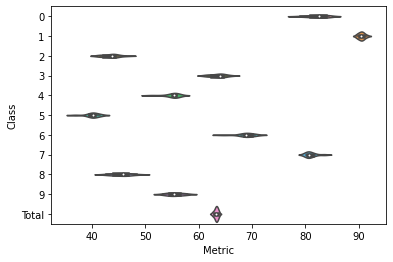

In [16]:
def get_xgboost():
    random_seed = np.random.randint(1024)
    return XGBClassifier(
        verbosity=0,
        random_state=random_seed,
        subsample=0.9,
        eta=0.1,
        use_label_encoder=False)

xgb_dframe = test_model(get_xgboost, 
                        (X, y),
                        100,
                        None, iters=10)

In [52]:
xgb_dframe[xgb_dframe["Class"]=="Total"].reset_index(drop=True)

,Class,Metric
0,Total,64.031720
1,Total,63.694491
2,Total,63.530885
3,Total,62.928214
4,Total,63.425710
5,Total,63.519199
6,Total,63.327212
7,Total,63.475793
8,Total,63.315526
9,Total,63.622705


### Random forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

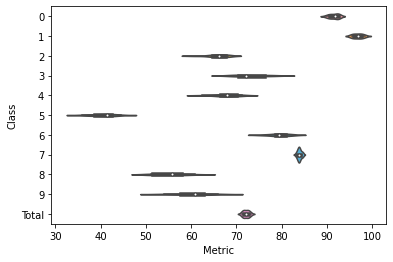

In [45]:
def get_rf(n_estimator):
    def _inner():
        random_seed = np.random.randint(1024)
        return RandomForestClassifier(
            random_state=random_seed)
    return _inner

rf_dframe = test_model(get_rf(estimators), 
                        (X, y),
                        100,
                        None, iters=10)

In [51]:
rf_dframe[rf_dframe["Class"]=="Total"].reset_index(drop=True).max()

Class         Total
Metric    73.155259
dtype: object

### HypernetworkPCA

In [111]:
def network_pca_fn(epochs=10, masks_no=100, mask_size=100):
    def _inner():
        hypernet = HypernetworkPCA(
                        target_architecture=[(mask_size, 100), (100, 10)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(16, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                        input_size=784
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

In [112]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

torch.Size([1, 128])
784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:44<00:00,  1.09s/it]


torch.Size([1, 128])
784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:29<00:00,  1.80s/it]


torch.Size([1, 128])
784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [02:44<00:00,  1.09s/it]


torch.Size([1, 128])
784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:48<00:00,  1.92s/it]
/tmp/ipykernel_3387654/2294287173.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results[mask_size][masks_no] = hyper_pca_results[hyper_pca_results["Class"]=="Total"].reset_index(drop=True).mean()


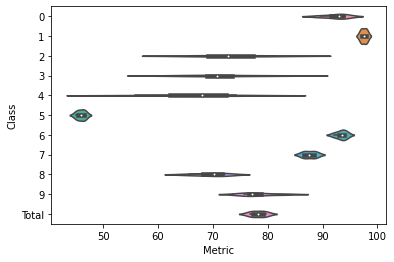

In [113]:
epochs = 150
mask_size = 50
masks_no = 100
data_size = 100
results = defaultdict(dict)

hyper_pca_results = test_model(network_pca_fn(epochs, masks_no, mask_size),
                (X, y),
                data_size,
                None, 4)
results[mask_size][masks_no] = hyper_pca_results[hyper_pca_results["Class"]=="Total"].reset_index(drop=True).mean()

# exp.log_table("metrics.csv", hyper_pca_results.groupby("Class").mean())

In [117]:
hyper_pca_results[hyper_pca_results["Class"]=="Total"].reset_index(drop=True).max()

Class         Total
Metric    79.611018
dtype: object

### Hypernetwork

In [16]:
def network_fn(epochs=10, masks_no=100, mask_size=100):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, 100), (100, 10)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(784, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

In [ ]:
epochs = 150
mask_size = 80
masks_no = 100
data_size = 100
# results = defaultdict(dict)

nn_results = test_model(network_fn(epochs, masks_no, mask_size),
                (X, y),
                data_size,
                None, 4)
results[mask_size][masks_no] = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean()

torch.Size([1, 128])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:38<00:00,  1.52it/s]


torch.Size([1, 128])


 47%|███████████████████████████████████████████████████████████▎                                                                   | 70/150 [02:12<02:34,  1.93s/it]

In [84]:
nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).max()

Class         Total
Metric    78.974958
dtype: object

Text(0.5, 1.0, 'Accuracy vs parameters')

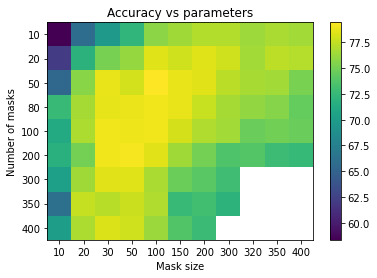

In [87]:
res_df = pd.DataFrame(results)
res_df = res_df.fillna(res_df.iloc[0, 0])
res_df = res_df.apply(lambda x: [i[0] if not isinstance(i, float) else i for i in x])
res_df = res_df.loc[:, sorted(res_df.columns)]
plt.imshow(res_df)
plt.yticks(np.arange(len(res_df)), res_df.index);
plt.xticks(np.arange(len(res_df.columns)), res_df.columns);
plt.xlabel("Mask size")
plt.ylabel("Number of masks")
plt.colorbar()
plt.title("Accuracy vs parameters")

In [97]:
res_df

,10,20,30,50,100,150,200,300,320,350,400
10,58.372287,65.863940,69.756678,72.218698,75.782137,76.437813,76.962437,76.985810,76.320534,76.738731,76.505426
20,62.079299,71.933639,75.136895,76.060100,78.363940,77.933222,78.408180,77.870618,76.481219,77.333472,77.084725
50,65.389816,75.664441,78.727045,77.997913,79.419032,78.694491,78.503339,77.222037,76.639816,76.511269,75.187813
80,72.590150,76.605593,78.643573,78.789232,79.005008,78.717863,77.631052,76.590150,75.983723,75.625626,74.436978
100,71.251669,76.804674,78.936978,78.876461,78.948247,78.023790,76.873539,76.524624,74.591820,74.946578,74.570952
200,71.723289,75.037563,78.945326,79.141486,78.507930,76.437813,75.053005,73.651920,73.748748,72.785893,72.484140
300,70.271703,76.404841,78.472871,78.381052,76.777963,74.710768,74.075125,72.976210,NaN,NaN,NaN
350,66.117279,77.535476,77.161102,77.738314,76.894825,72.527546,73.026294,71.957846,NaN,NaN,NaN
400,70.086394,76.842654,78.332220,77.928214,76.235810,73.696160,72.708681,NaN,NaN,NaN,NaN


### Neural network

In [67]:
def network_fn():
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(1-700/784),
                        torch.nn.Linear(784, 100),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(0.5),
                        torch.nn.Linear(100, 10)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=150, batch_size=32)
        return network
    return _inner

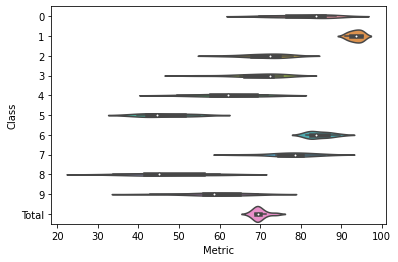

In [68]:
data_size = 100

nn_results = test_model(network_fn(),
                (X, y),
                data_size,
                None, 10)

In [72]:
nn_results[nn_results["Class"]=="Total"].reset_index(drop=True)

,Class,Metric
0,Total,69.295492
1,Total,71.482471
2,Total,69.442404
3,Total,67.570952
4,Total,73.928214
5,Total,69.030050
6,Total,70.273790
7,Total,69.377295
8,Total,68.782972
9,Total,69.527546


### TabNet

In [39]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [44]:
def tabnet_fn():
    clf = TabNetClassifier(verbose=1,n_d=64, n_a=64, n_steps=5,
        gamma=1.5, n_independent=2, n_shared=2,
        cat_emb_dim=1,
        lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2))
    return clf

tabnet_results = test_model(tabnet_fn,
                    (X, y),
                    1024, None, 1, as_numpy=True)

epoch 0  | loss: 4.49442 |  0:00:00s
epoch 1  | loss: 4.10065 |  0:00:00s
epoch 2  | loss: 3.69994 |  0:00:00s
epoch 3  | loss: 3.47651 |  0:00:00s
epoch 4  | loss: 3.53598 |  0:00:00s
epoch 5  | loss: 3.38709 |  0:00:01s
epoch 6  | loss: 3.26813 |  0:00:01s
epoch 7  | loss: 3.2686  |  0:00:01s
epoch 8  | loss: 3.1316  |  0:00:01s
epoch 9  | loss: 3.13288 |  0:00:01s
epoch 10 | loss: 2.90717 |  0:00:01s
epoch 11 | loss: 2.95466 |  0:00:01s
epoch 12 | loss: 2.85828 |  0:00:02s
epoch 13 | loss: 2.76352 |  0:00:02s
epoch 14 | loss: 2.74836 |  0:00:02s
epoch 15 | loss: 2.78355 |  0:00:02s
epoch 16 | loss: 2.78048 |  0:00:02s
epoch 17 | loss: 2.60539 |  0:00:02s
epoch 18 | loss: 2.60996 |  0:00:03s
epoch 19 | loss: 2.57146 |  0:00:03s
epoch 20 | loss: 2.58619 |  0:00:03s
epoch 21 | loss: 2.50692 |  0:00:03s
epoch 22 | loss: 2.51857 |  0:00:03s
epoch 23 | loss: 2.4401  |  0:00:03s
epoch 24 | loss: 2.3768  |  0:00:03s
epoch 25 | loss: 2.36941 |  0:00:04s
epoch 26 | loss: 2.29808 |  0:00:04s
e

In [34]:
tabnet_results[tabnet_results["Class"]=="Total"].reset_index(drop=True)

,Class,Metric
0,Total,61.61659


### NODE

In [14]:
from qhoptim.pyt import QHAdam
import node

In [15]:
X_init = X.reshape(-1, 784)

In [37]:
def node_fn(layer_dims):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_init.shape[1], layer_dims, num_layers=2, tree_dim=11, depth=6, flatten_output=False,
                           choice_function=node.entmax15, bin_function=node.entmoid15),
            node.Lambda(lambda x: x[..., :10].mean(dim=-2))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_init[:1000], device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=500, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

In [ ]:
exp = Experiment(os.environ.get("COMET_KEY"), "mnist-benchmark-hypernet")
exp.add_tag("node")

node_results = test_model(node_fn(512),
                            (X, y),
                            100,
                            None, 10
                         )
plt.title(layers)
plt.show()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/wwydmanski/mnist-benchmark-hypernet/6d8d95615641402b98577a488e29c52c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [200] : (0.3375752866268158, 2.302137851715088)
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (42.67 KB)
COMET INFO:     installed packages           : 1
COMET INFO:     model graph                  : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COM

In [50]:
node_results[node_results["Class"]=="Total"].reset_index(drop=True)

,Class,Metric
0,Total,75.242070
1,Total,74.041736
2,Total,75.803005
3,Total,75.988314
4,Total,74.517529
5,Total,75.666110
6,Total,76.679466
7,Total,74.490818
8,Total,75.302170
9,Total,76.133556
